# DCGAN - MNIST


In [ ]:
#10 epochs
#Standard DCGAN setup (PyTorch)
# images scaled to [-1,1]
# log losses, D(x)-D(G(z)), D-accuracy, G-fooling, and gradient norms for stability
import random, time, math, os
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils as vutils
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

EPOCHS     = 10
BATCH_SIZE = 128
NZ         = 100   #LATENT NOIDE DIM
NGF        = 64    #Generator 
NDF        = 64    #Discriminator 
NC         = 1     #MNIST 
IMG_SIZE   = 28
BETAS      = (0.5, 0.999)

USE_DROPOUT_D       = True    
USE_INSTANCE_NOISE  = True 
USE_LABEL_SMOOTHING = True   
USE_LABEL_FLIP      = True   

D_LR = 1e-4   #Discriminator 
G_LR = 2e-4   #Generatir

NOISE_START = 0.08
NOISE_END   = 0.00


Device: cpu


In [ ]:
#MNIST 
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) 
])

train_ds = datasets.MNIST("./data", train=True, download=True, transform=transform)
train_loader = DataLoader(
    train_ds, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=2, 
    pin_memory=True)

print("Train batches:", len(train_loader))

x,_ = next(iter(train_loader))


Train batches: 469


In [ ]:
#Models (Generator and Discriminator)
class View(nn.Module):
    def __init__(self, *shape):
        super().__init__(); self.shape = shape
    def forward(self, x):
        return x.view(self.shape)

def weights_init_dcgan(m):
    cname = m.__class__.__name__
    if "Conv" in cname or "Linear" in cname:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if getattr(m, "bias", None) is not None:
            nn.init.zeros_(m.bias.data)
    elif "BatchNorm" in cname:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.zeros_(m.bias.data)

class Generator(nn.Module):
    def __init__(self, nz=100, ngf=64, nc=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(nz, ngf*7*7, bias=False),
            nn.BatchNorm1d(ngf*7*7),
            nn.ReLU(True),
            View(-1, ngf, 7, 7),                            
            nn.ConvTranspose2d(ngf, ngf//2, 4, 2, 1, bias=False), 
            nn.BatchNorm2d(ngf//2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf//2, nc, 4, 2, 1, bias=False), 
            nn.Tanh()
        )
    def forward(self, z): return self.net(z)

class Discriminator(nn.Module):
    def __init__(self, ndf=64, nc=1, use_dropout=True):
        super().__init__()
        Drop = (lambda p: nn.Dropout2d(p)) if use_dropout else (lambda p: nn.Identity())
        self.net = nn.Sequential(
            nn.Conv2d(nc, ndf//2, 4, 2, 1, bias=False),  
            nn.LeakyReLU(0.2, inplace=True),
            Drop(0.2),
            nn.Conv2d(ndf//2, ndf, 4, 2, 1, bias=False),  
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True),
            Drop(0.2),
            nn.Flatten(),
            nn.Linear(ndf*7*7, 1)                      
        )
    def forward(self, x): return self.net(x).view(-1)

G = Generator(NZ, NGF, NC).to(DEVICE)
D = Discriminator(NDF, NC, use_dropout=USE_DROPOUT_D).to(DEVICE)
G.apply(weights_init_dcgan); D.apply(weights_init_dcGAN) if False else None
D.apply(weights_init_dcgan)



Discriminator(
  (net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout2d(p=0.2, inplace=False)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Dropout2d(p=0.2, inplace=False)
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=3136, out_features=1, bias=True)
  )
)

In [4]:
criterion = nn.BCEWithLogitsLoss()
optD = torch.optim.Adam(D.parameters(), lr=D_LR, betas=BETAS)
optG = torch.optim.Adam(G.parameters(), lr=G_LR, betas=BETAS)

fixed_z = torch.randn(64, NZ, device=DEVICE)  


In [5]:
def add_instance_noise(x, sigma):
    if not USE_INSTANCE_NOISE or sigma <= 0: 
        return x
    noise = torch.randn_like(x) * sigma
    return torch.clamp(x + noise, -1, 1)


Epoch 1/10: 100%|██████████| 469/469 [00:18<00:00, 25.53it/s, D=0.926, DGz=0.277, Dacc=0.867, Dx=0.663, G=1.45, Gfool=0.0705]


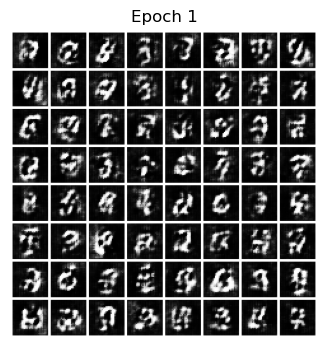

Epoch 2/10: 100%|██████████| 469/469 [00:19<00:00, 24.02it/s, D=1.13, DGz=0.344, Dacc=0.741, Dx=0.553, G=1.18, Gfool=0.146]


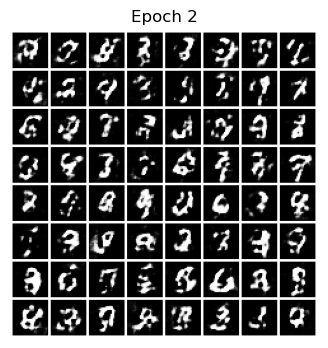

Epoch 3/10: 100%|██████████| 469/469 [00:18<00:00, 24.84it/s, D=1.15, DGz=0.352, Dacc=0.731, Dx=0.548, G=1.15, Gfool=0.15] 


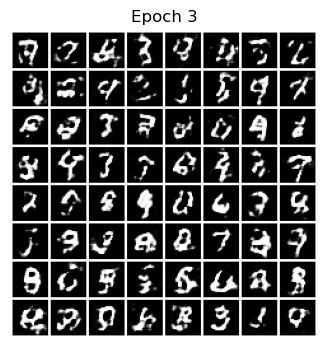

Epoch 4/10: 100%|██████████| 469/469 [00:20<00:00, 23.23it/s, D=1.16, DGz=0.354, Dacc=0.718, Dx=0.545, G=1.16, Gfool=0.16] 


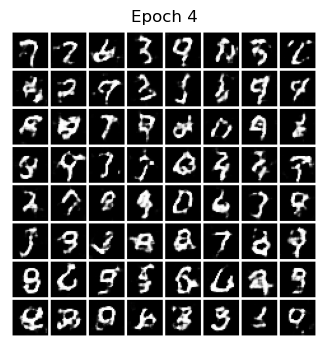

Epoch 5/10: 100%|██████████| 469/469 [00:20<00:00, 23.14it/s, D=1.22, DGz=0.37, Dacc=0.688, Dx=0.53, G=1.1, Gfool=0.186]   


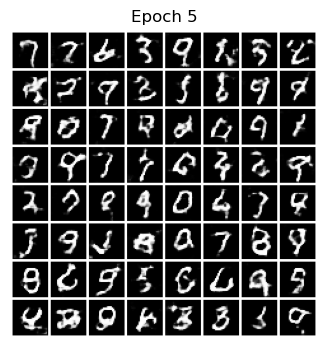

Epoch 6/10: 100%|██████████| 469/469 [00:21<00:00, 21.66it/s, D=1.24, DGz=0.381, Dacc=0.67, Dx=0.519, G=1.05, Gfool=0.2]   


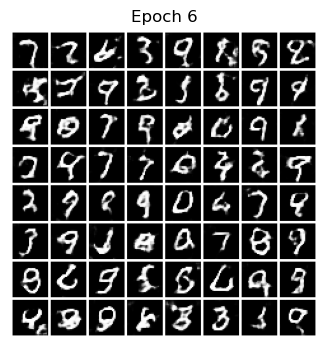

Epoch 7/10: 100%|██████████| 469/469 [00:21<00:00, 21.70it/s, D=1.26, DGz=0.389, Dacc=0.656, Dx=0.512, G=1.03, Gfool=0.207]


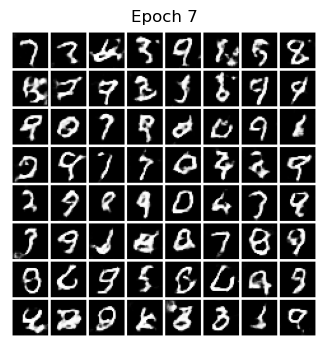

Epoch 8/10: 100%|██████████| 469/469 [00:21<00:00, 22.17it/s, D=1.27, DGz=0.393, Dacc=0.65, Dx=0.507, G=1.01, Gfool=0.215] 


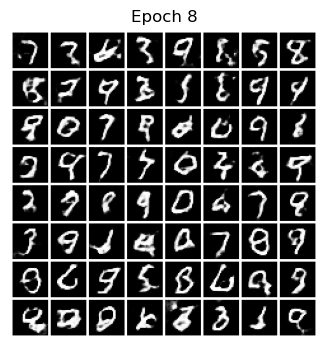

Epoch 9/10: 100%|██████████| 469/469 [00:21<00:00, 21.44it/s, D=1.27, DGz=0.395, Dacc=0.647, Dx=0.505, G=1.01, Gfool=0.209]


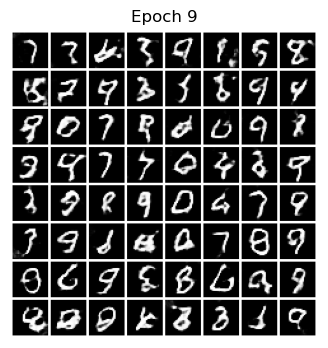

Epoch 10/10: 100%|██████████| 469/469 [00:22<00:00, 21.25it/s, D=1.28, DGz=0.396, Dacc=0.645, Dx=0.504, G=0.999, Gfool=0.215]


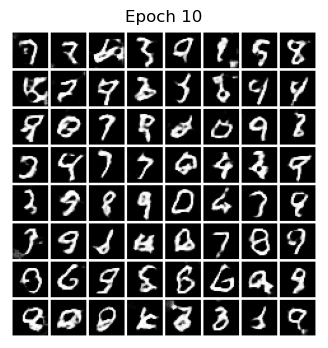

In [ ]:
#Training 10 epochs
history = {
    "G_loss":[], 
    "D_loss":[], 
    "Dx":[], 
    "DGz":[], 
    "D_acc":[], 
    "G_fool":[], 
    "G_grad":[], 
    "D_grad":[]}

snapshots = []

def grad_norm(model):
    s = 0.0
    for p in model.parameters():
        if p.grad is not None:
            s += p.grad.data.pow(2).sum().item()
    return math.sqrt(s)

for epoch in range(1, EPOCHS+1):
    G.train(); D.train()
    G_epoch, D_epoch, Dx_epoch, DGz_epoch = [], [], [], []
    Dacc_epoch, Gfool_epoch = [], []
    Ggrad_epoch, Dgrad_epoch = [], []

    sigma = NOISE_START + (NOISE_END - NOISE_START) * (epoch-1) / max(1, (EPOCHS-1))

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}")

    for real, _ in pbar:
        real = real.to(DEVICE)

        #training D
        optD.zero_grad(set_to_none=True)

        #real
        logits_real = D(add_instance_noise(real, sigma))
        if USE_LABEL_SMOOTHING:
            labels_real = torch.empty_like(logits_real).uniform_(0.8, 1.0)
        else:
            labels_real = torch.ones_like(logits_real)
        loss_real = criterion(logits_real, labels_real)
        Dx = torch.sigmoid(logits_real).mean().item()

        #fake
        z = torch.randn(real.size(0), NZ, device=DEVICE)
        fake = G(z).detach()
        logits_fake = D(add_instance_noise(fake, sigma))
        labels_fake = torch.zeros_like(logits_fake)
        loss_fake = criterion(logits_fake, labels_fake)
        DGz = torch.sigmoid(logits_fake).mean().item()
        acc_real = (torch.sigmoid(logits_real) >= 0.5).float().mean().item()
        acc_fake = (torch.sigmoid(logits_fake) <  0.5).float().mean().item()
        D_acc = 0.5 * (acc_real + acc_fake)

        if USE_LABEL_FLIP and random.random() < 0.02:
            lossD = criterion(logits_real, labels_fake) + criterion(logits_fake, labels_real)
        else:
            lossD = loss_real + loss_fake

        lossD.backward()
        Dgrad_epoch.append(grad_norm(D))
        optD.step()

        #training G
        optG.zero_grad(set_to_none=True)
        z = torch.randn(real.size(0), NZ, device=DEVICE)
        fake = G(z)
        logits_fake_for_G = D(add_instance_noise(fake, sigma))
        lossG = criterion(logits_fake_for_G, torch.ones_like(logits_fake_for_G)) 
        G_fool = (torch.sigmoid(logits_fake_for_G) > 0.5).float().mean().item()
        lossG.backward()
        Ggrad_epoch.append(grad_norm(G))
        optG.step()

        G_epoch.append(lossG.item()); D_epoch.append(lossD.item())
        Dx_epoch.append(Dx); DGz_epoch.append(DGz)
        Dacc_epoch.append(D_acc); Gfool_epoch.append(G_fool)

        pbar.set_postfix(G=np.mean(G_epoch), D=np.mean(D_epoch), 
                         Dx=np.mean(Dx_epoch), DGz=np.mean(DGz_epoch),
                         Dacc=np.mean(Dacc_epoch), Gfool=np.mean(Gfool_epoch))

    history["G_loss"].append(float(np.mean(G_epoch)))
    history["D_loss"].append(float(np.mean(D_epoch)))
    history["Dx"].append(float(np.mean(Dx_epoch)))
    history["DGz"].append(float(np.mean(DGz_epoch)))
    history["D_acc"].append(float(np.mean(Dacc_epoch)))
    history["G_fool"].append(float(np.mean(Gfool_epoch)))
    history["G_grad"].append(float(np.mean(Ggrad_epoch)))
    history["D_grad"].append(float(np.mean(Dgrad_epoch)))

    #snapshot from fixed noise
    with torch.no_grad():
        G.eval()
        samples = G(fixed_z).cpu()
        grid = vutils.make_grid(samples, nrow=8, normalize=True, value_range=(-1,1), pad_value=1.0)
        snapshots.append(grid)

    plt.figure(figsize=(4,4))
    plt.imshow(grid.permute(1,2,0).squeeze(), cmap="gray")
    plt.axis("off"); 
    plt.title(f"Epoch {epoch}")
    plt.show()


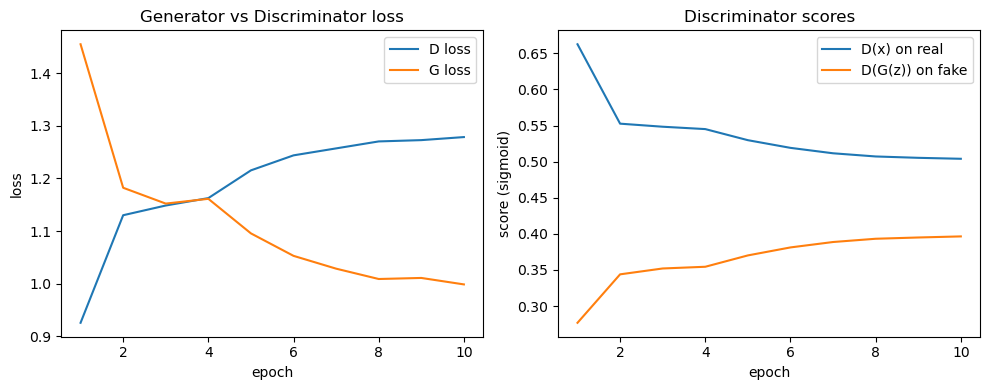

In [ ]:
#Loss and Scores for plot
epochs = np.arange(1, len(history["G_loss"])+1)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(epochs, history["D_loss"], label="D loss")
plt.plot(epochs, history["G_loss"], label="G loss")
plt.xlabel("epoch"); 
plt.ylabel("loss"); 
plt.title("Generator vs Discriminator loss"); 
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, history["Dx"], label="D(x) on real")

plt.plot(epochs, history["DGz"], label="D(G(z)) on fake")
plt.xlabel("epoch"); 
plt.ylabel("score (sigmoid)"); 
plt.title("Discriminator scores"); 
plt.legend()
plt.tight_layout(); 
plt.show()


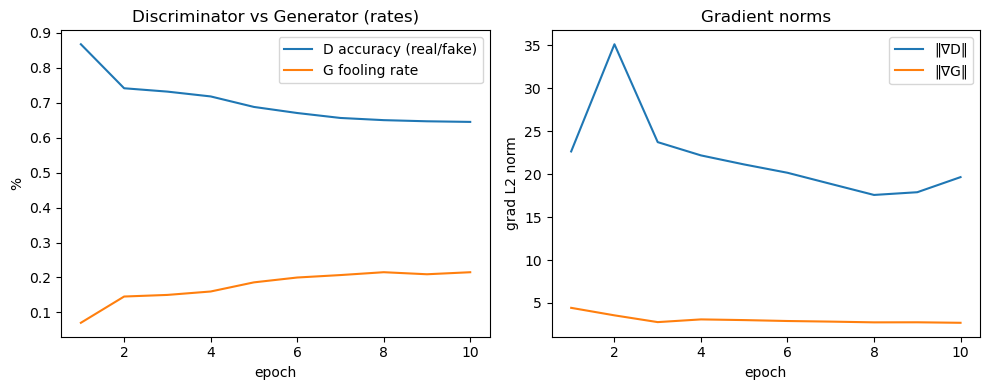

In [ ]:
epochs = np.arange(1, len(history["G_loss"])+1)

#D-accuracy and G-fooling, Gradient norms
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(epochs, history["D_acc"],  label="D accuracy (real/fake)")
plt.plot(epochs, history["G_fool"], label="G fooling rate")
plt.xlabel("epoch"); 
plt.ylabel("%"); 
plt.title("Discriminator vs Generator (rates)")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, history["D_grad"], label="‖∇D‖")
plt.plot(epochs, history["G_grad"], label="‖∇G‖")
plt.xlabel("epoch"); 
plt.ylabel("grad L2 norm"); 
plt.title("Gradient norms")
plt.legend()
plt.tight_layout(); 
plt.show()


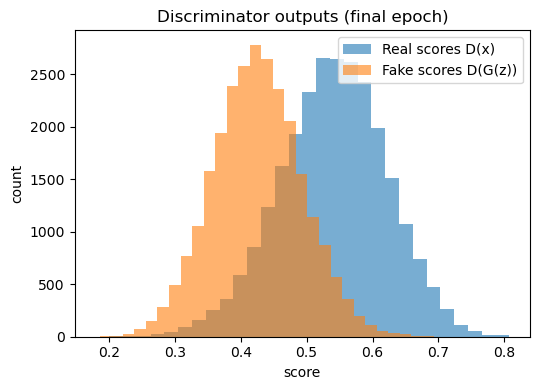

In [ ]:
#Final epoch D output histogram
with torch.no_grad():
    D.eval(); G.eval()
    logits_real_all, logits_fake_all = [], []
    for real, _ in DataLoader(train_ds, batch_size=512, shuffle=True):
        real = real.to(DEVICE)
        lr = D(real)
        z = torch.randn(real.size(0), NZ, device=DEVICE)
        lf = D(G(z))
        logits_real_all.append(torch.sigmoid(lr).cpu())
        logits_fake_all.append(torch.sigmoid(lf).cpu())
        if len(logits_real_all) > 50: 
            break
    R = torch.cat(logits_real_all).numpy()
    F = torch.cat(logits_fake_all).numpy()

plt.figure(figsize=(5.5,4))
plt.hist(R, bins=30, alpha=0.6, label="Real scores D(x)")
plt.hist(F, bins=30, alpha=0.6, label="Fake scores D(G(z))")
plt.xlabel("score"); plt.ylabel("count"); plt.title("Discriminator outputs (final epoch)")
plt.legend(); plt.tight_layout(); plt.show()


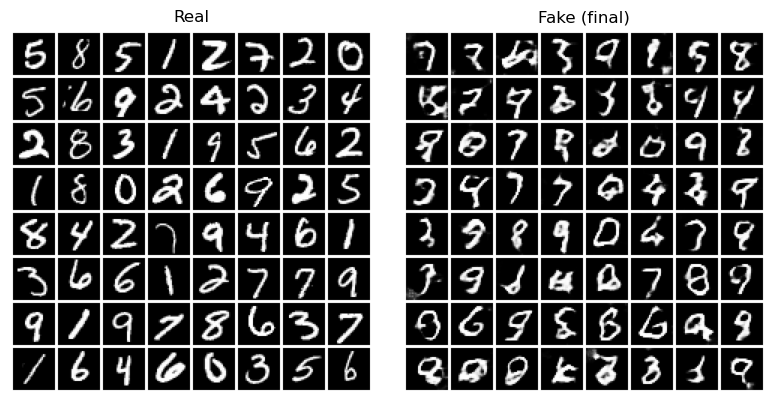

In [ ]:
#real and fake (final grid)
real_batch, _ = next(iter(train_loader))
real_grid = vutils.make_grid(real_batch[:64], nrow=8, 
                             normalize=True, value_range=(-1,1), pad_value=1.0)

latest_grid = snapshots[-1]

plt.figure(figsize=(8,4))
plt.subplot(1,2,1); 
plt.imshow(real_grid.permute(1,2,0).squeeze(), cmap="gray"); 
plt.axis("off"); 
plt.title("Real")
plt.subplot(1,2,2); 
plt.imshow(latest_grid.permute(1,2,0).squeeze(), cmap="gray"); 
plt.axis("off"); 
plt.title("Fake (final)")
plt.tight_layout(); 
plt.show()


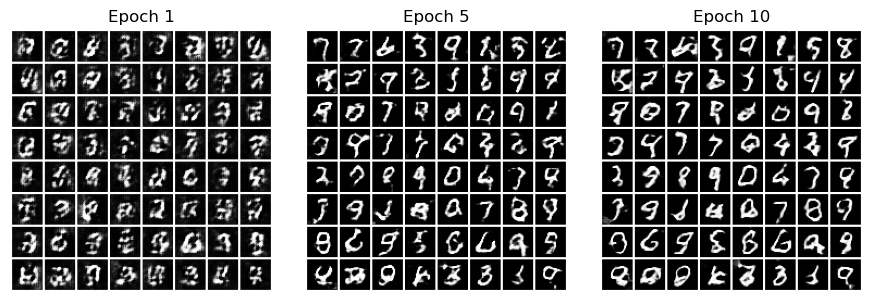

In [11]:
def show_progress(snapshots, which=(1,5,10)):
    which = [i for i in which if 1 <= i <= len(snapshots)]
    cols = len(which)
    plt.figure(figsize=(3*cols, 3))

    for j, ep in enumerate(which, start=1):
        plt.subplot(1, cols, j)
        plt.imshow(snapshots[ep-1].permute(1,2,0).squeeze(), cmap="gray")
        plt.axis("off"); 
        plt.title(f"Epoch {ep}")

    plt.tight_layout(); 
    plt.show()

show_progress(snapshots)  #default 1 5 10
